# DaCapo Tail Latency Curve

## 1. Copy latency hdr files to this machine

```console
$ rsync -azR --no-i-r -h --info=progress2 squirrel.moma:/home/wenyuz/./MMTk-Dev/evaluation/results/log/lxr-latency-bear-2023-12-21-Thu-114935 /home/wenyuz
```

## 2. Plot curves

In [2]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from enum import Enum
import matplotlib as mpl
from pathlib import Path

In [3]:
class LatencyType(Enum):
    METERED = 'metered'
    SIMPLE = 'simple'

LATENCY_TYPE = LatencyType.METERED

RUNIDS = [
    'lxr-latency-bear-2024-01-28-Sun-065734',
]

SAVE_FILE = 'pdf'
# SAVE_FILE = 'jpg'
# SAVE_FILE = None

MAX_INVOCATIONS = 40
MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000 * 1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

LABEL_FONT_SIZE = 30
LEGEND_FONT_SIZE = 30
TICK_FONT_SIZE = 25
TITLE_FONT_SIZE=35

GCS = ['lxr', 'g1', 'shenandoah', 'z']
GC_NAMES = ['LXR', 'G1', 'Shen.', 'ZGC']

In [4]:
# plt.rcParams["font.family"] = "Linux Biolinum"

def load_latency_data(bench: str, latency_type: LatencyType, folder: Path):
    folders = list(folder.glob(f"{bench}.*"))
    print(f"[{bench}] Loading histograms from {len(folders)} folders ...")
    histograms: dict[str, list[HdrHistogram]] = {}
    for i, child in enumerate(folders, start=1):
        if not child.is_dir(): continue
        parts = child.name.split(".")
        gc = parts[4]
        if gc == "Z" and parts[6] == "zgc_gen": gc = "GenZ"
        bench = parts[0]
        for hdr in child.glob(f"*-{latency_type.value}-4.hdr"):
            parts = hdr.stem.split("-")
            with hdr.open("r") as fd:
                hist_raw = fd.read().split(",")[3]
                hist = HdrHistogram.decode(hist_raw)
                if gc not in histograms: histograms[gc] = []
                histograms[gc].append(hist)
    return histograms

def load_data_and_plot(bench: str, save: bool = False, latency_type: LatencyType = LATENCY_TYPE, legend: str | bool = True, max_percentile='99.999'):
    print(f'[{bench}] Loading ...')
    # Load data
    histograms = {}
    for runid in RUNIDS:
        hists = load_latency_data(bench, latency_type, Path(f'/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}'))
        for gc, h in hists.items():
            if gc not in histograms: histograms[gc] = []
            histograms[gc].extend(h)
    # Process data
    histograms_len = sum([len(x) for x in histograms.values()])
    print(f'[{bench}] Processing {histograms_len} histograms ...')
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_list.sort(key=lambda x: GCS.index(x["GC"]))
    max_gcs = len(set(x["GC"] for x in percentile_list))
    percentile_df = pd.DataFrame(percentile_list)
    percentile_df["other"] = 1 / (1 - percentile_df["percentile"])
    # Plot curves
    print(f'[{bench}] Plotting ...')
    fig, ax = plt.subplots(1,1,figsize=(16,12))
    fig.suptitle(f'{bench}', fontsize=TITLE_FONT_SIZE)
    sns.color_palette()
    sns.lineplot(data=percentile_df, x="other", y="value", hue="GC", palette=['green', 'blue', 'orange', 'red'][:max_gcs])
    ax.set_xscale('log')
    ax.set_xlabel('Percentile', fontsize=LABEL_FONT_SIZE, labelpad=12)
    ax.set_ylabel('Latency (msec)', fontsize=LABEL_FONT_SIZE, labelpad=12)
    labels = ['0', '90', '99', '99.9', '99.99', '99.999', '99.9999']
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000][:labels.index(max_percentile) + 1])
    ax.set_xticklabels(labels[:labels.index(max_percentile) + 1], fontsize=TICK_FONT_SIZE)
    plt.yticks(fontsize=TICK_FONT_SIZE)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}'.format(x)))
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,3,0]
    if legend == False:
        plt.legend([], [], frameon=False)
    elif legend == True:
        plt.legend([handles[i] for i in order if i < len(handles)], [GC_NAMES[GCS.index(labels[i])] for i in order if i < len(labels)],  fontsize=LEGEND_FONT_SIZE)
    else:
        plt.legend([handles[i] for i in order if i < len(handles)], [GC_NAMES[GCS.index(labels[i])] for i in order if i < len(labels)], fontsize=LEGEND_FONT_SIZE, loc=legend)
    plt.tight_layout()
    # Dump figure to file
    if save:
        print(f'[{bench}] Save to latency-{bench}.{SAVE_FILE}')
        plt.savefig(f'latency-{bench}.{SAVE_FILE}', bbox_inches='tight')

# lusearch

[lusearch] Loading ...
[lusearch] Loading histograms from 79 folders ...
[lusearch] Processing 75 histograms ...
[lusearch] Plotting ...


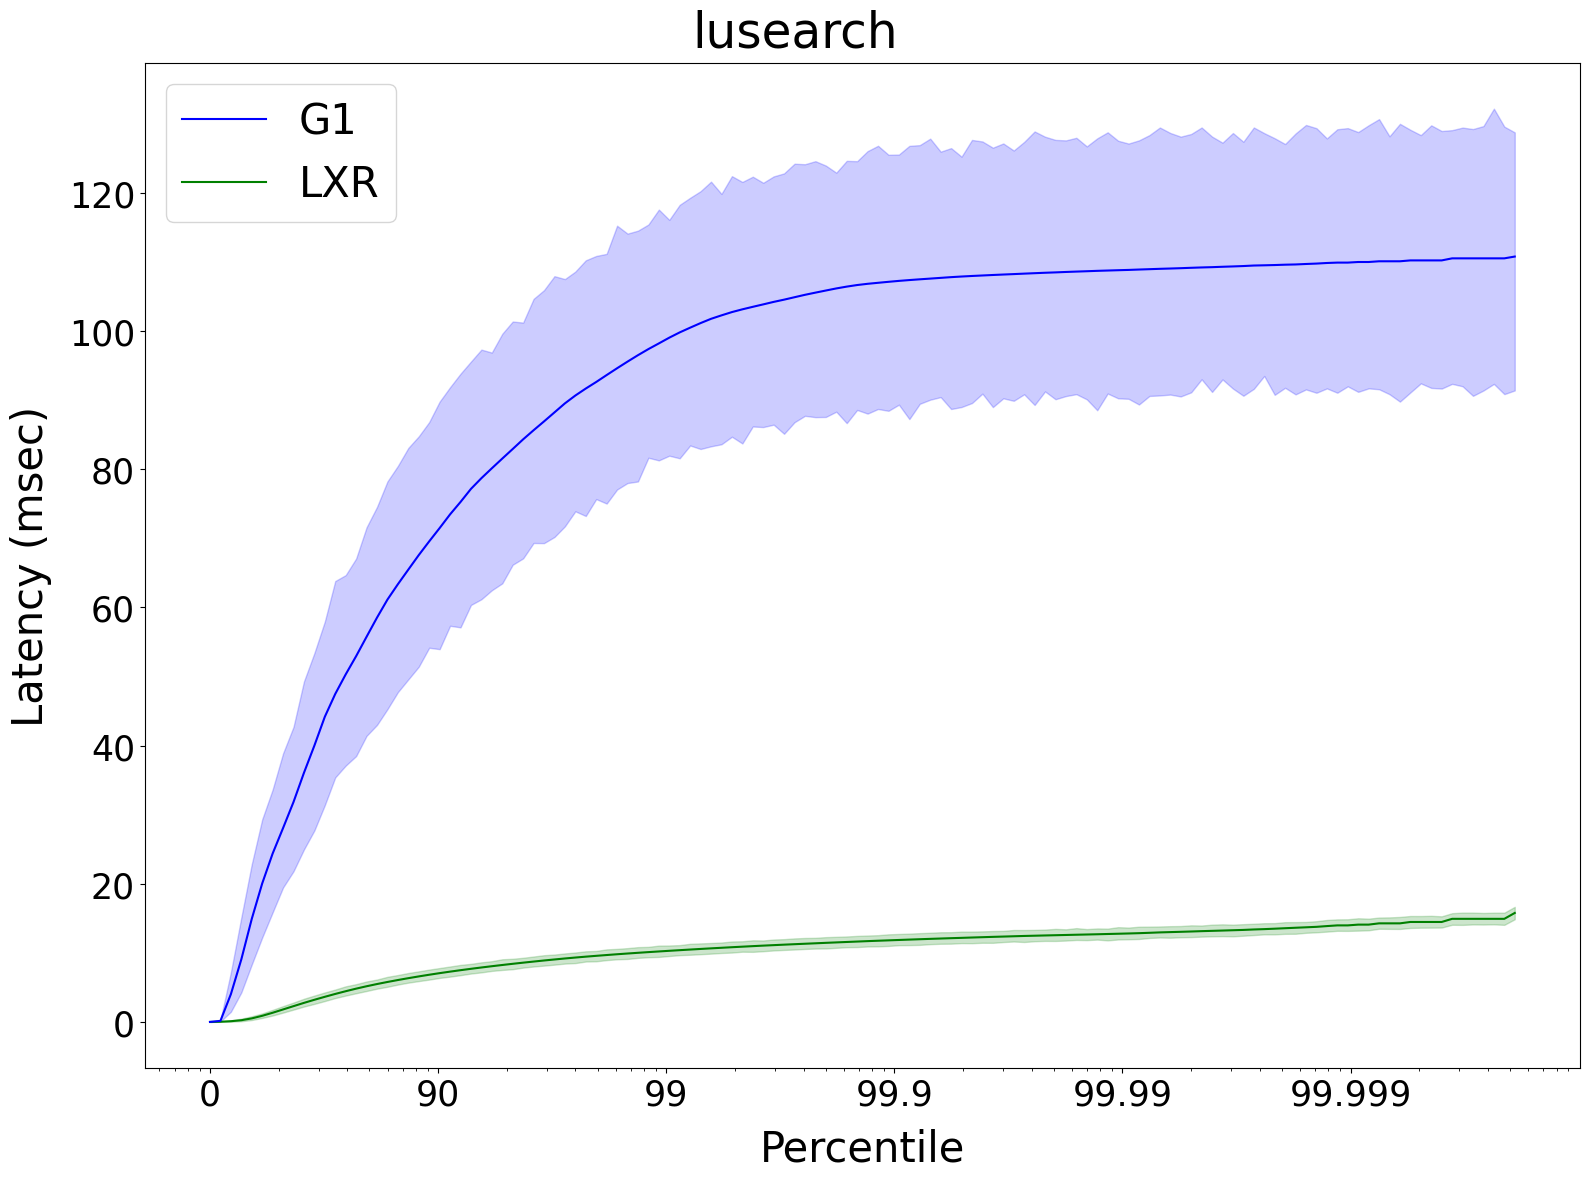

In [5]:
load_data_and_plot(bench='lusearch', legend='upper left')

# cassandra

[cassandra] Loading ...
[cassandra] Loading histograms from 124 folders ...
[cassandra] Processing 120 histograms ...
[cassandra] Plotting ...


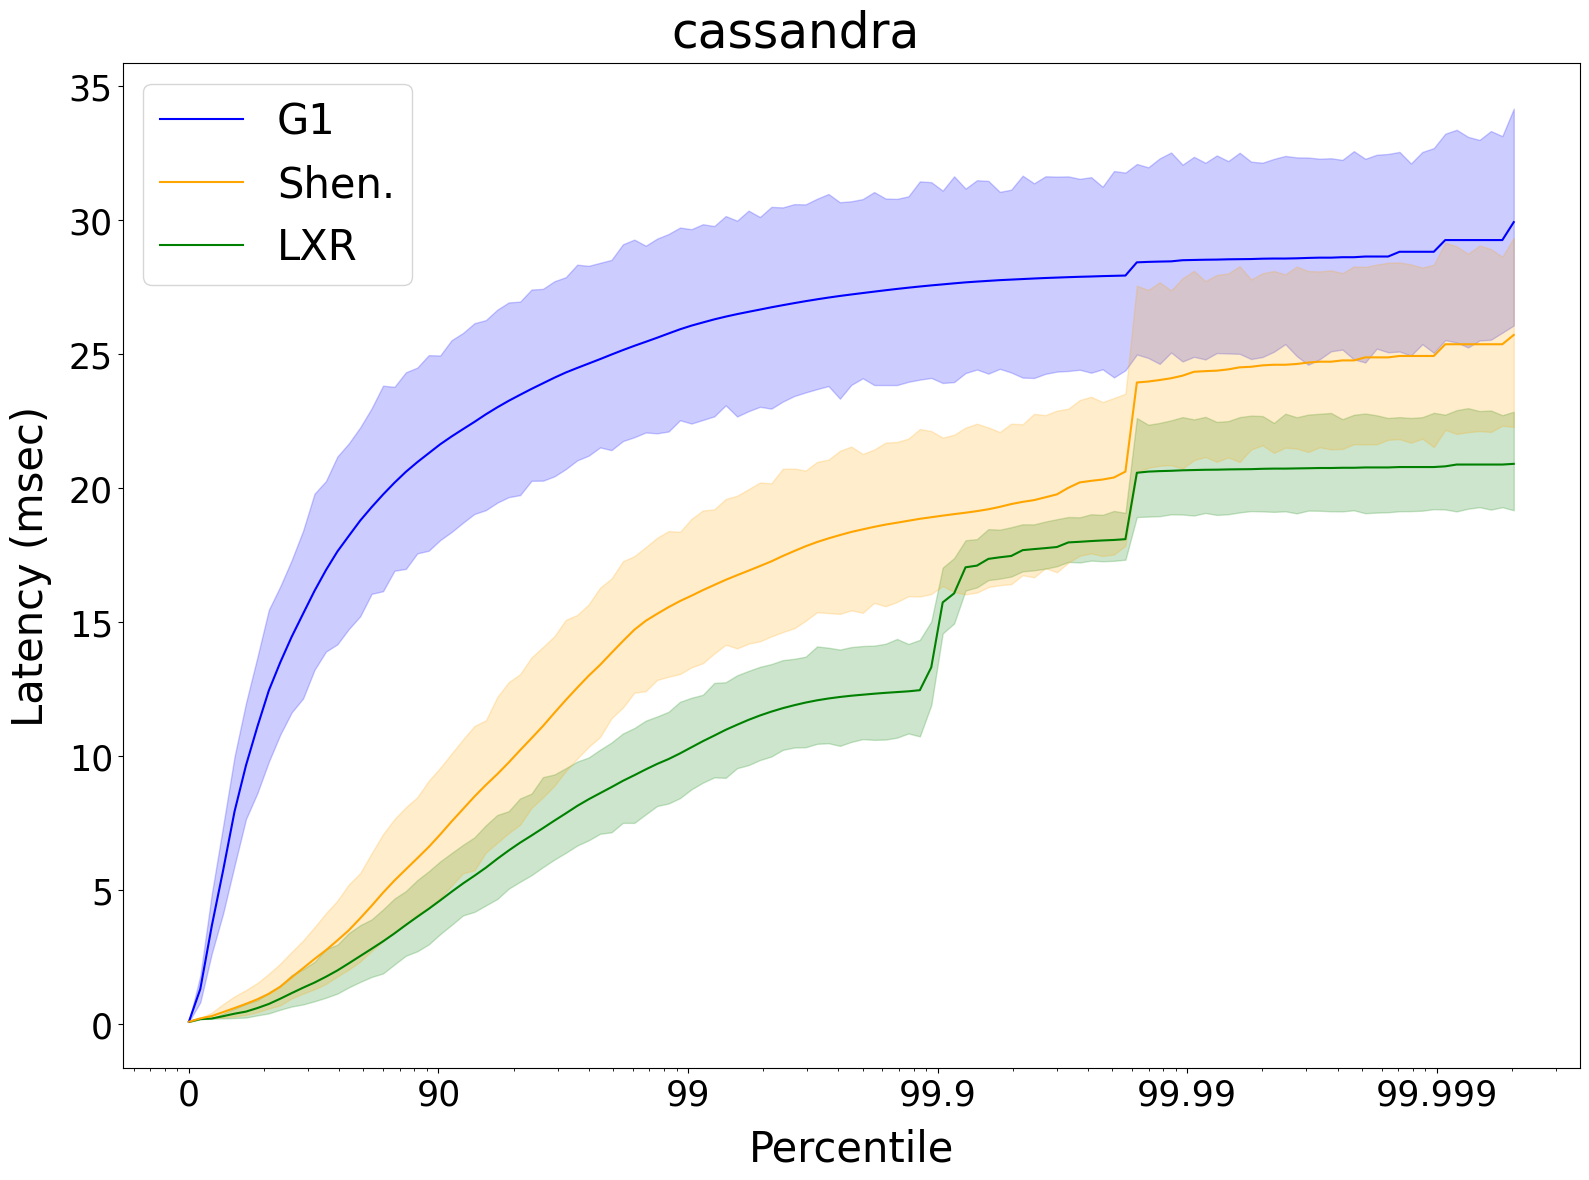

In [6]:
load_data_and_plot(bench='cassandra', legend='upper left')

# h2

[h2] Loading ...
[h2] Loading histograms from 162 folders ...
[h2] Processing 158 histograms ...
[h2] Plotting ...


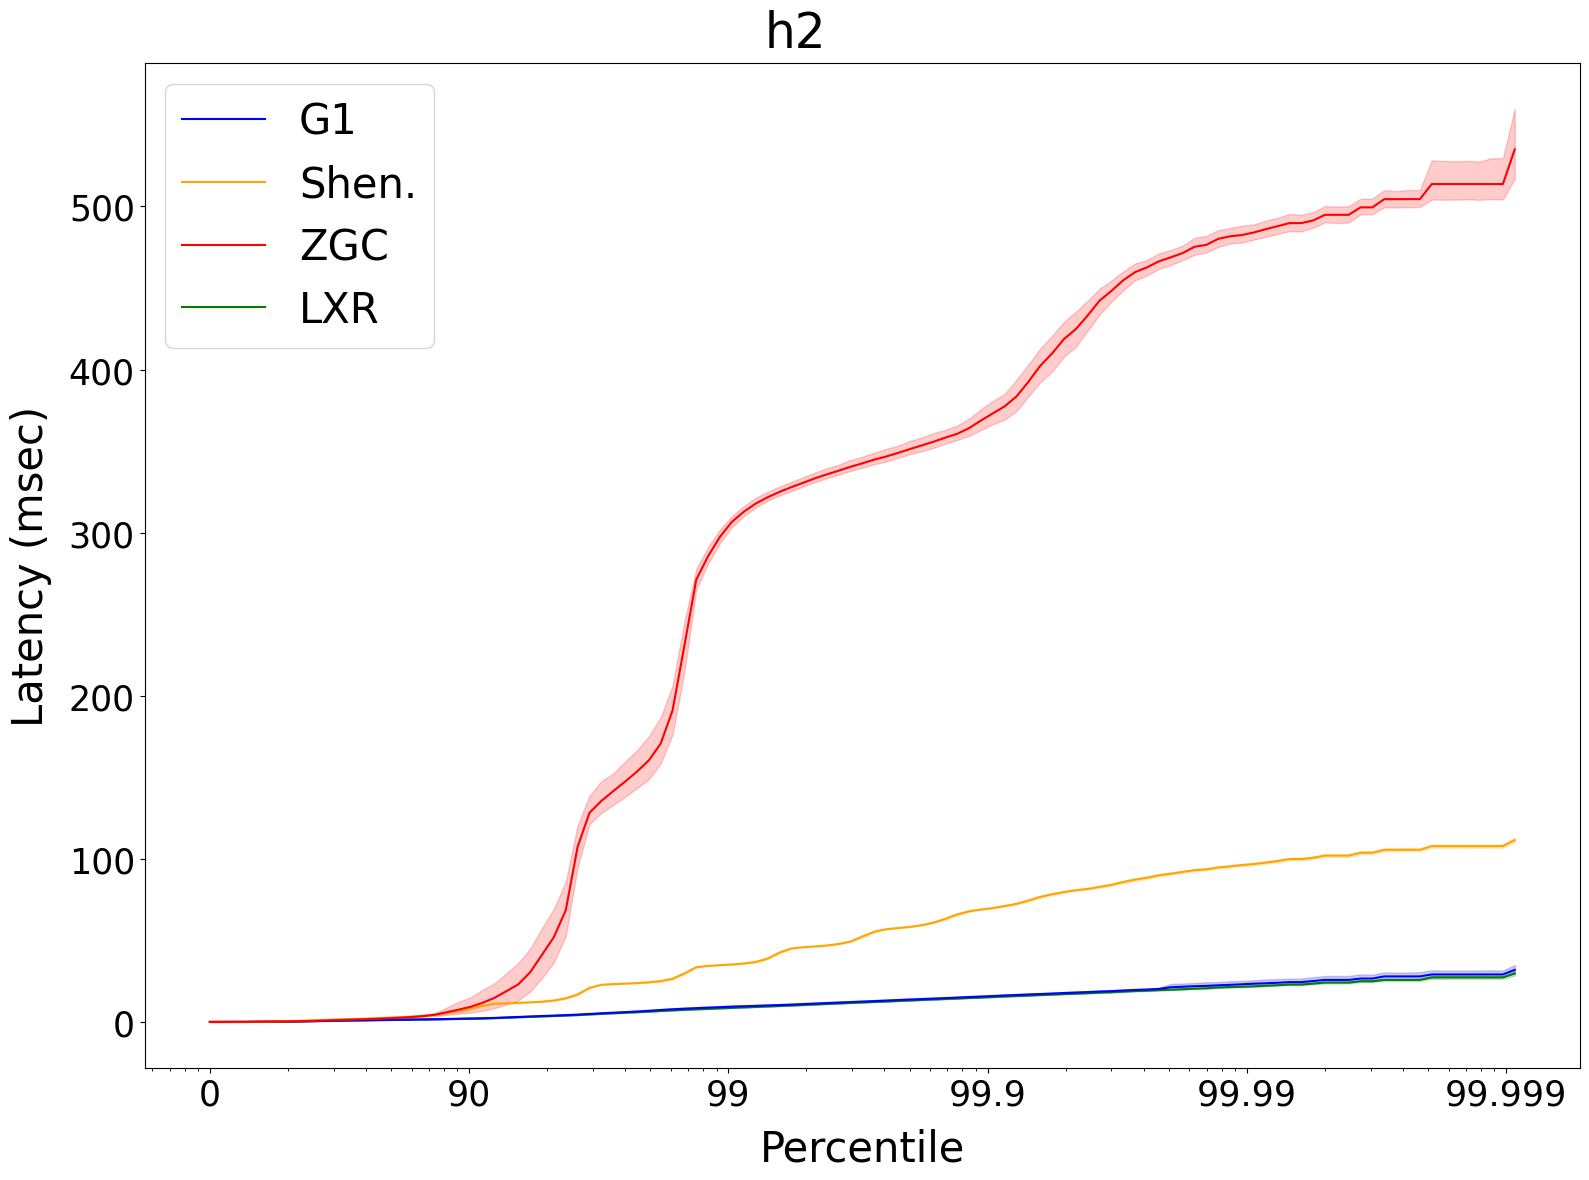

In [5]:
load_data_and_plot(bench='h2', legend='upper left')

# spring

[spring] Loading ...
[spring] Loading histograms from 124 folders ...
[spring] Processing 120 histograms ...
[spring] Plotting ...


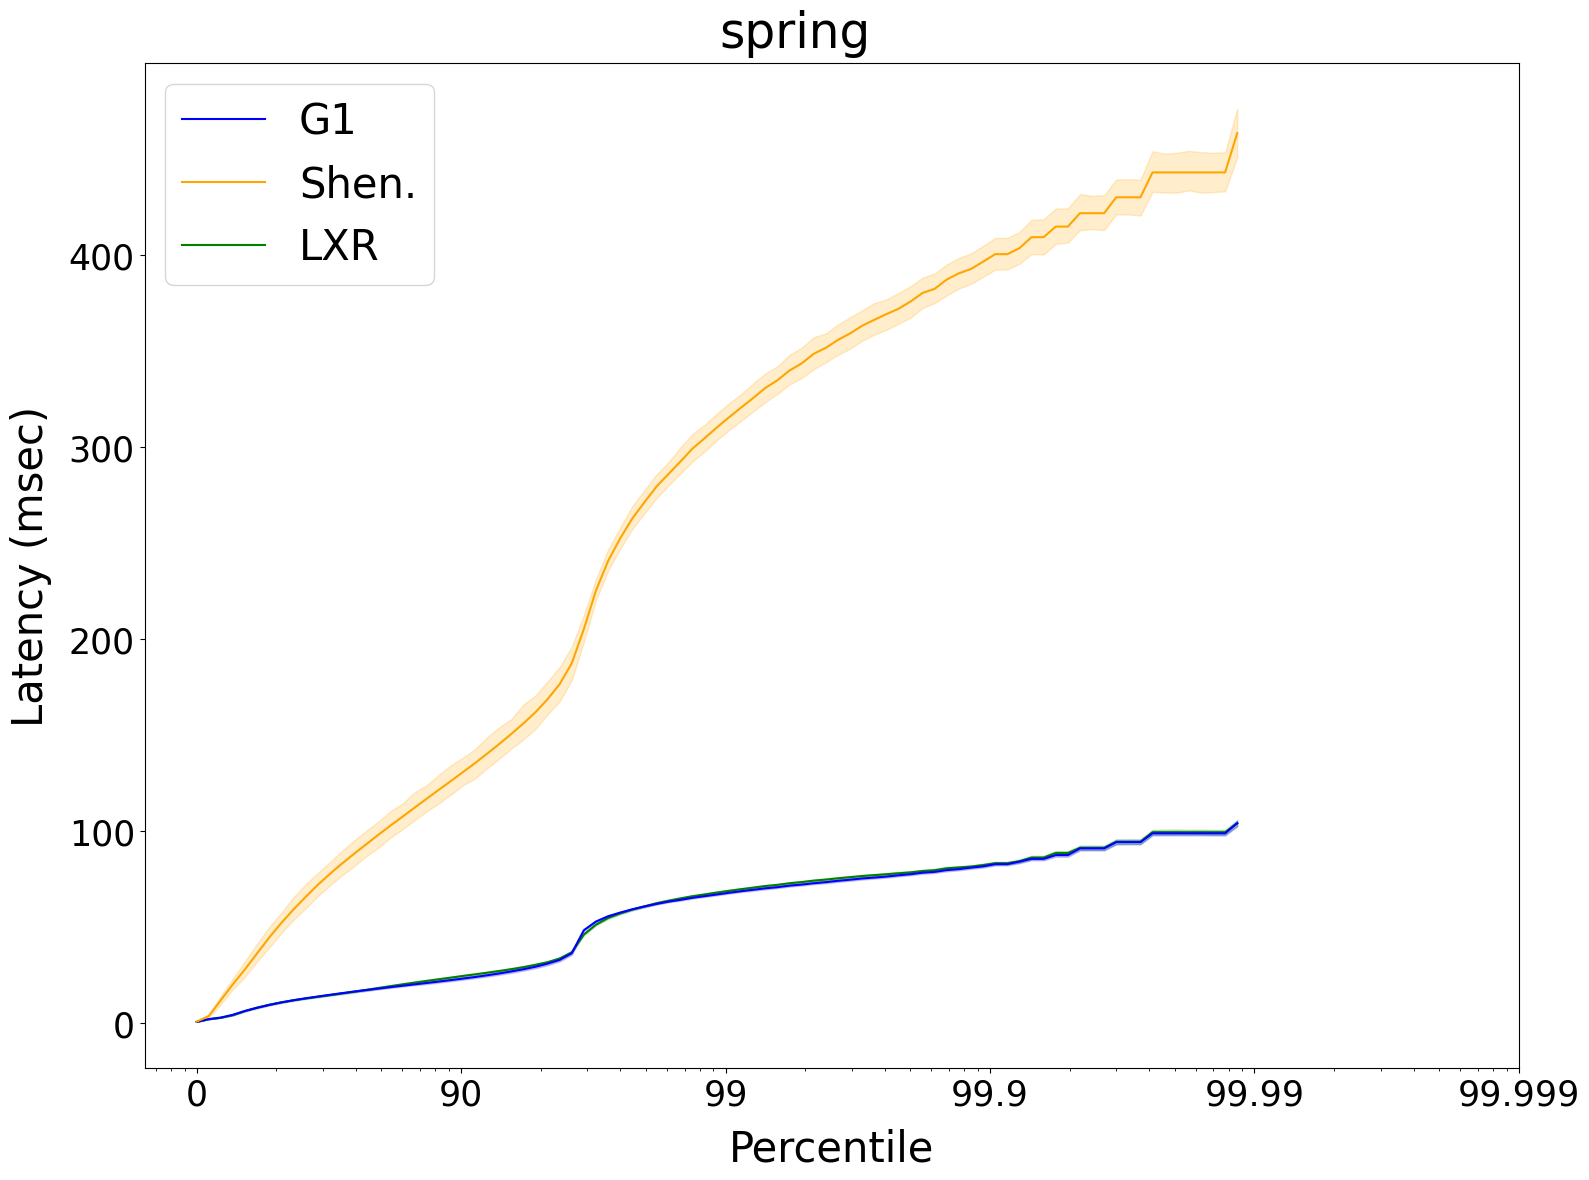

In [15]:
load_data_and_plot(bench='spring', legend='upper left')

# tradesoap

[tradesoap] Loading ...
[tradesoap] Loading histograms from 124 folders ...
[tradesoap] Processing 120 histograms ...
[tradesoap] Plotting ...


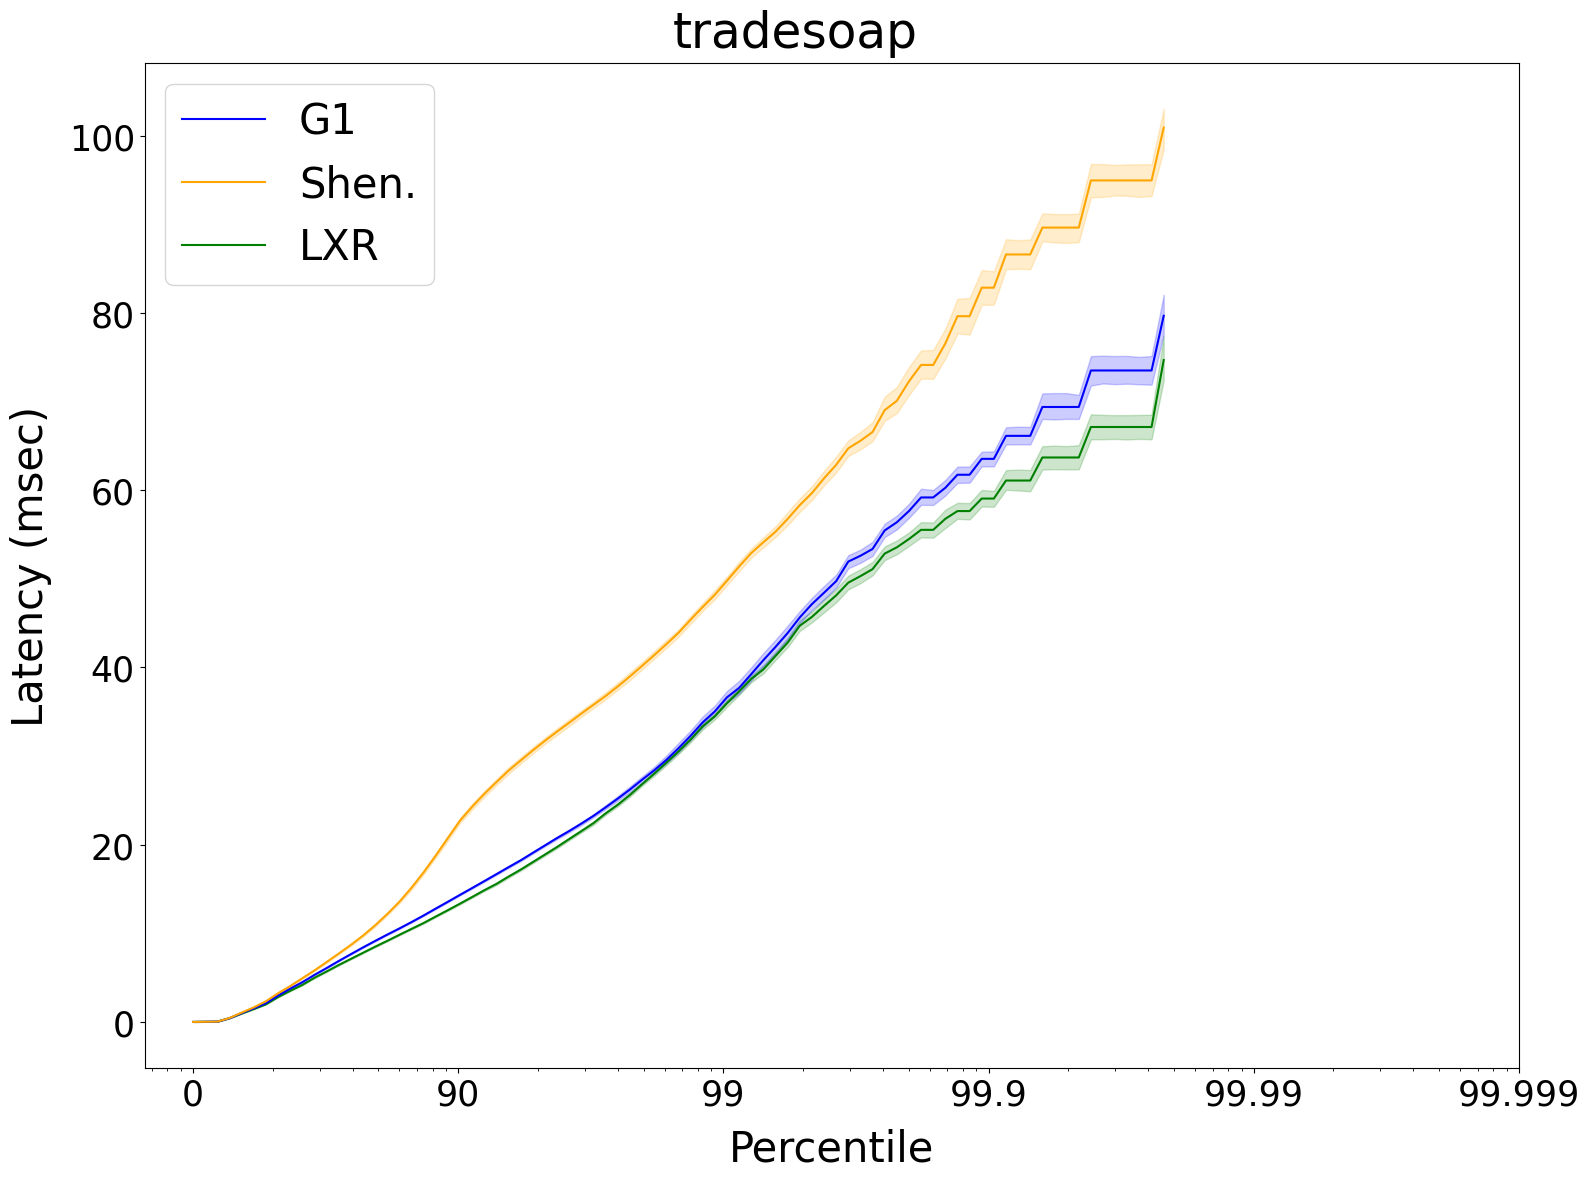

In [6]:
load_data_and_plot(bench='tradesoap', legend='upper left')

# tradebeans

[tradebeans] Loading ...
[tradebeans] Loading histograms from 124 folders ...
[tradebeans] Processing 120 histograms ...
[tradebeans] Plotting ...


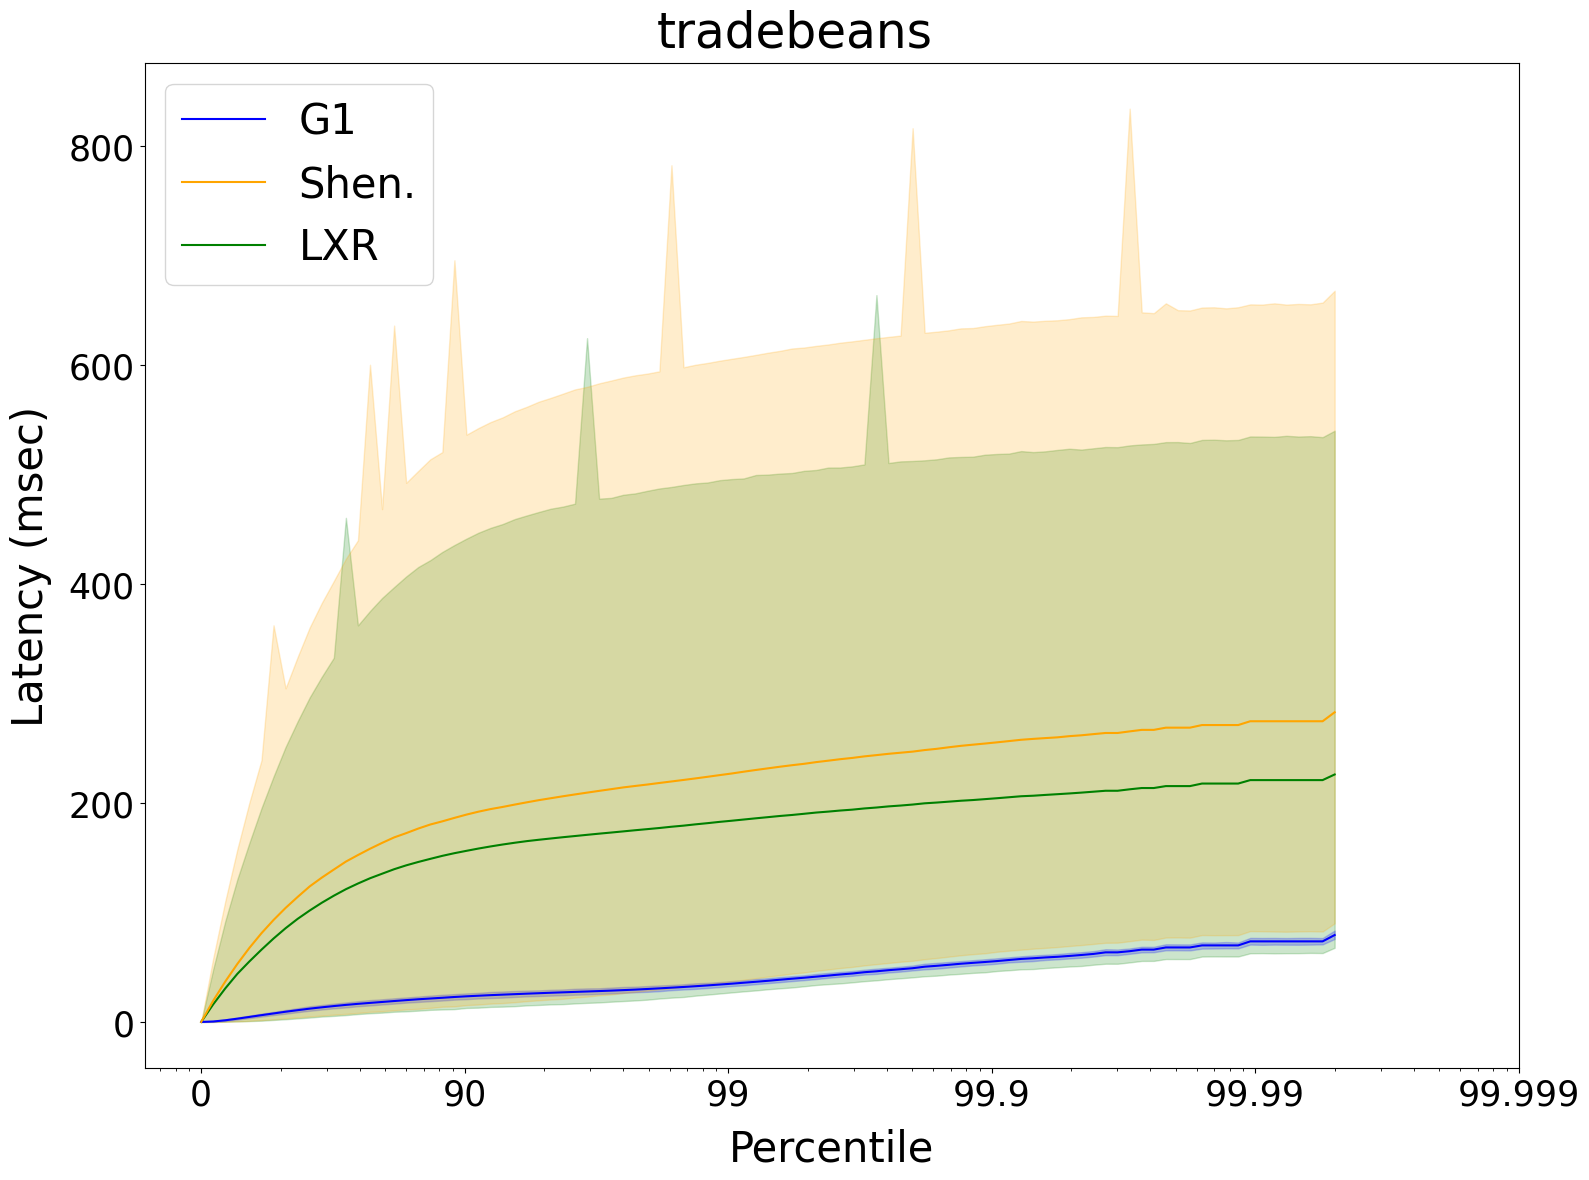

In [7]:
load_data_and_plot(bench='tradebeans', legend='upper left')

# tomcat

[tomcat] Loading ...
[tomcat] Loading histograms from 124 folders ...
[tomcat] Processing 120 histograms ...
[tomcat] Plotting ...


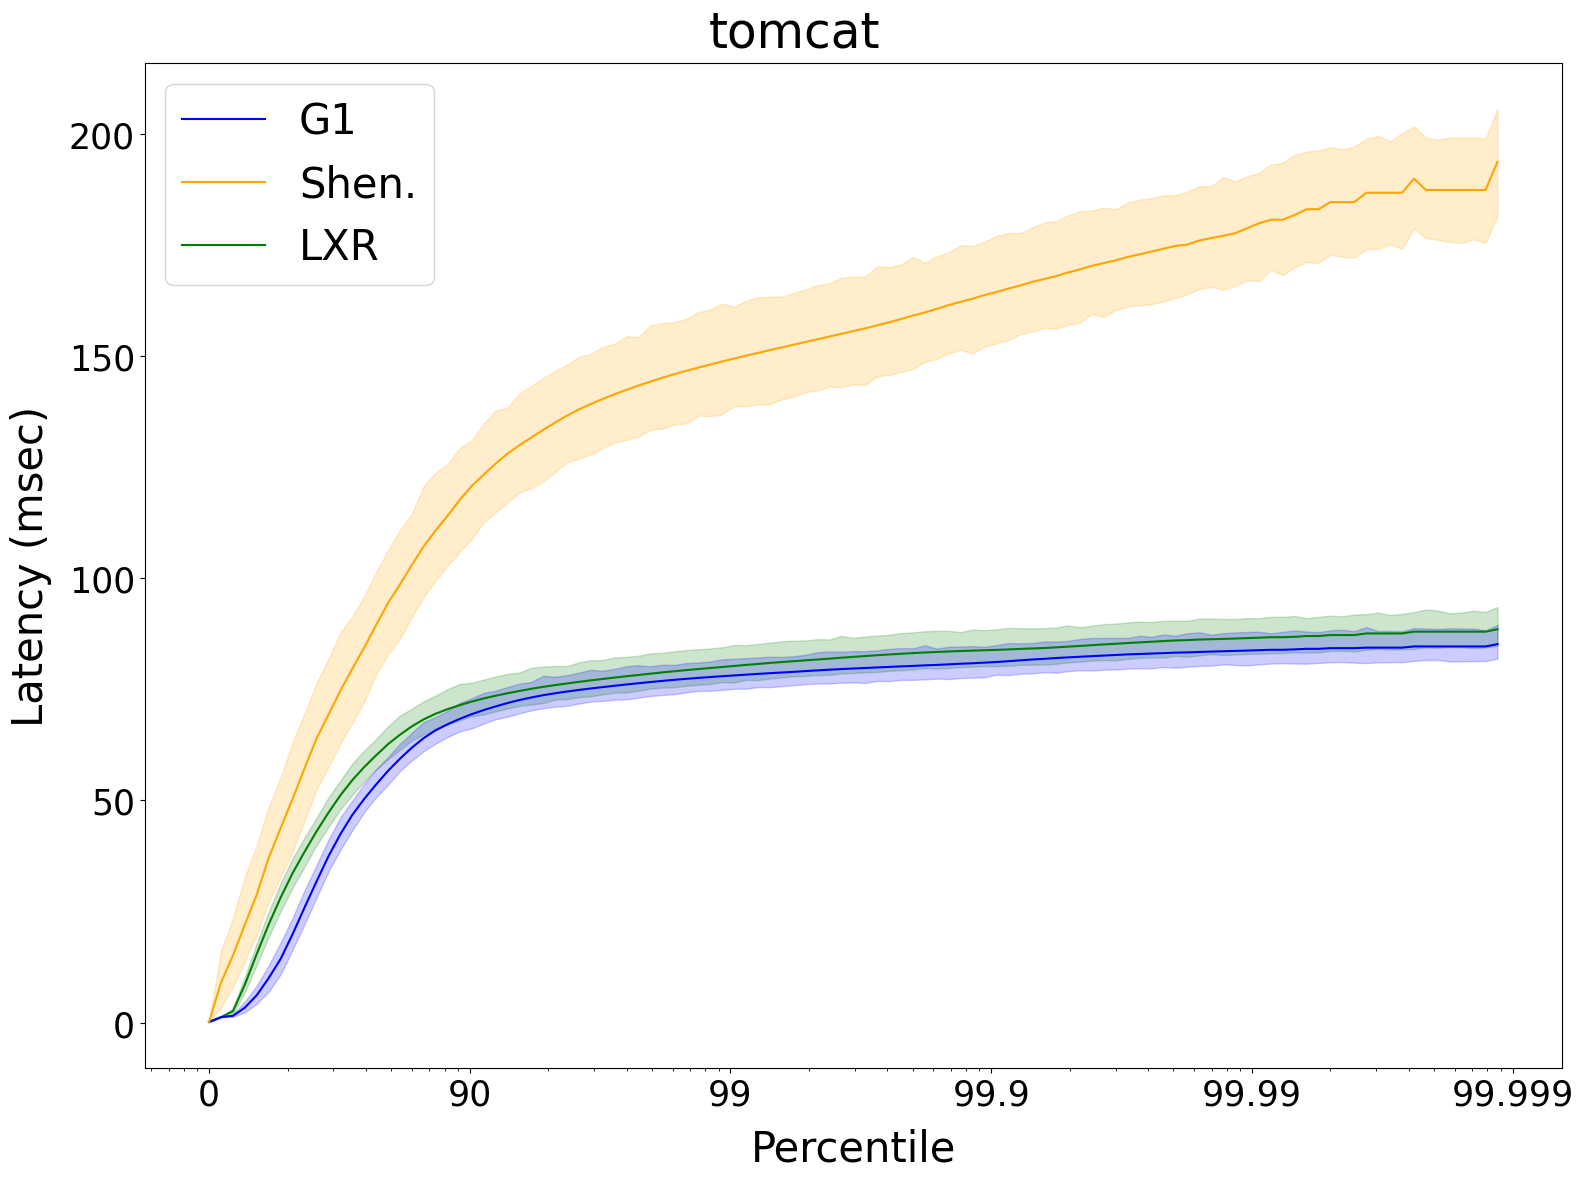

In [8]:
load_data_and_plot(bench='tomcat', legend='upper left')

# kafka

[kafka] Loading ...
[kafka] Loading histograms from 124 folders ...
[kafka] Processing 120 histograms ...
[kafka] Plotting ...


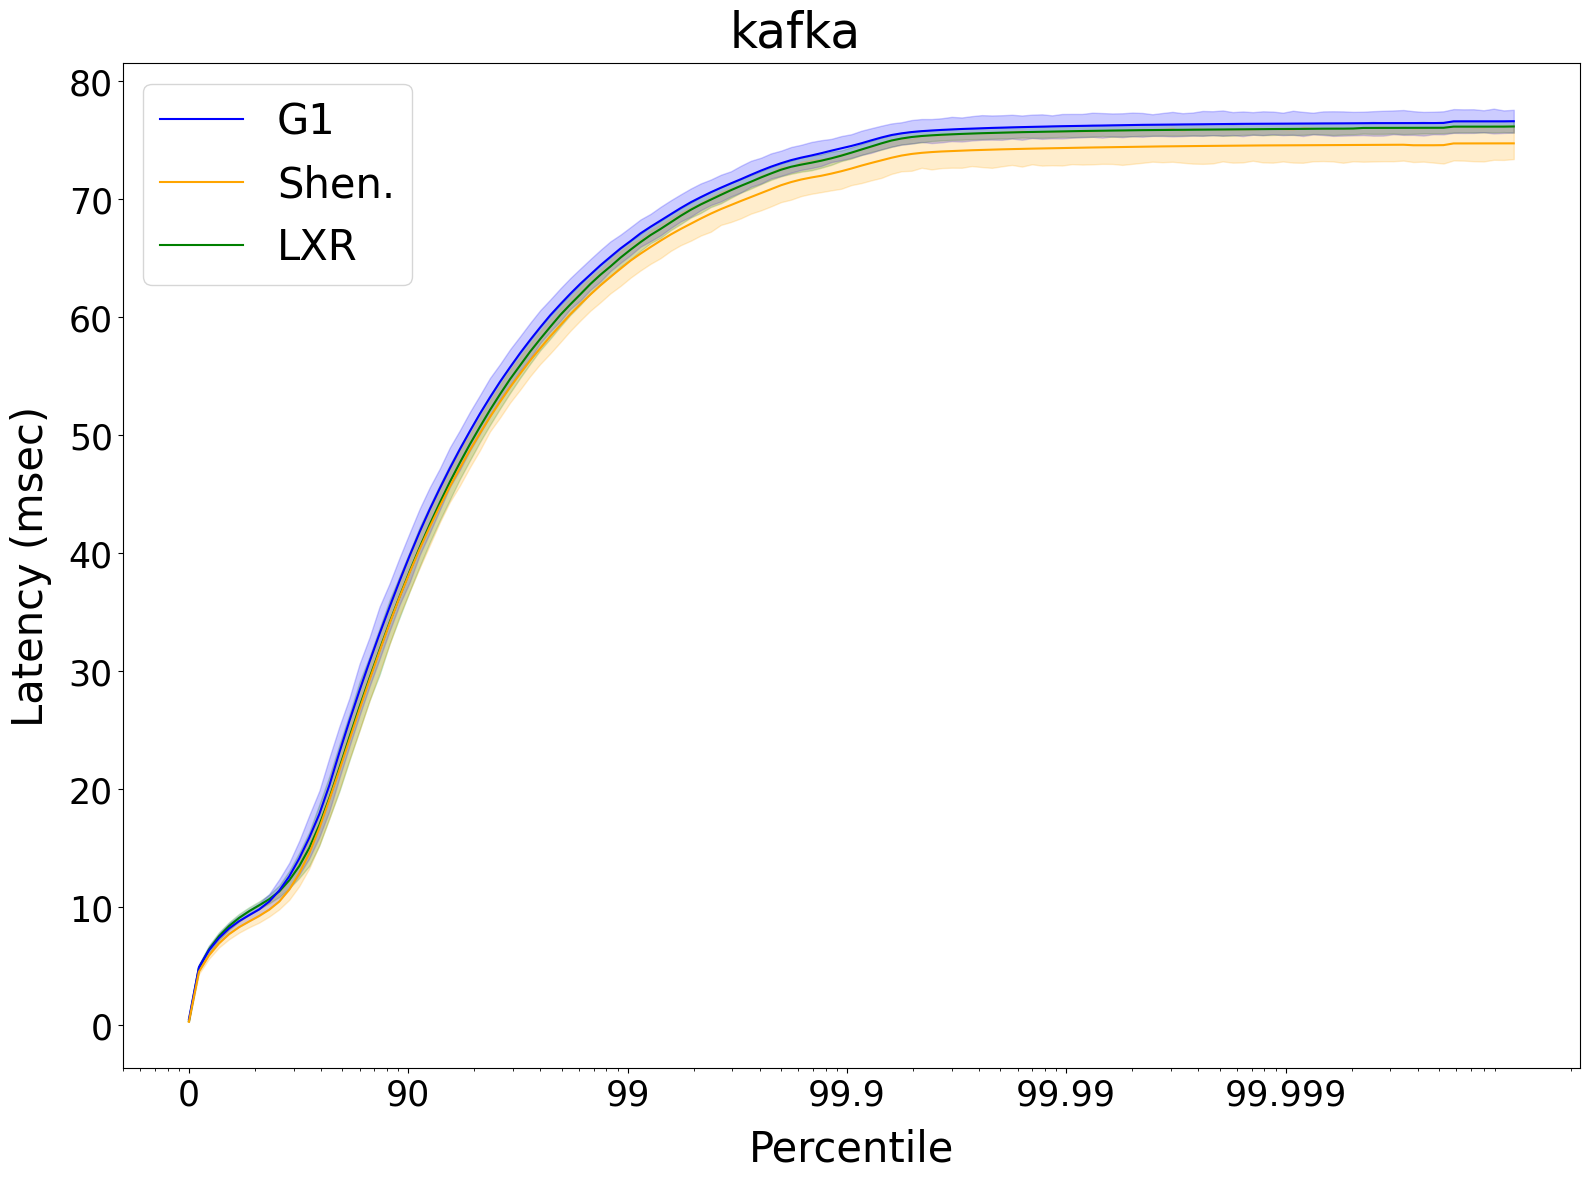

In [9]:
load_data_and_plot(bench='kafka', legend='upper left')